#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


In [1]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/mini_project_3'

* 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Input, concatenate
from keras.backend import clear_session
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

#### 1) 데이터로딩

In [ ]:
train_data=pd.read_csv('/content/drive/MyDrive/project3/data01_train.csv')
test_data=pd.read_csv('/content/drive/MyDrive/project3/data01_test.csv')
train_data.drop('subject', axis=1, inplace=True)
test_data.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [ ]:
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


## **2. 데이터 전처리**

### (1) 데이터 분할1 : x, y

In [ ]:
x = train_data.drop('Activity', axis=1)
y = train_data.loc[:, 'Activity']

### (2) 스케일링


In [ ]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

### (3) Y 전처리

In [ ]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

### (4) 데이터분할2 : train, validation

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)

## **3. 기본 모델링**



In [ ]:
model_scores = pd.DataFrame()

In [ ]:
import numpy as np
from scipy import stats

def calculate_confidence_interval(accuracy, n, confidence_level=0.95):
    """
    정확도와 샘플 수를 기반으로 신뢰 구간을 계산하는 함수.

    Parameters:
    - accuracy: 모델의 정확도 (0 ~ 1)
    - n: 샘플 수 (검증 데이터 또는 테스트 데이터 샘플 수)
    - confidence_level: 신뢰 수준 (기본값 95%)

    Returns:
    - (lower_bound, upper_bound): 신뢰 구간의 하한과 상한
    """
    # 신뢰 수준에 따른 z 값 계산 (95% 신뢰 구간의 z 값: 1.96)
    z = stats.norm.ppf(1 - (1 - confidence_level) / 2)

    # 신뢰 구간 계산
    interval_margin = z * np.sqrt((accuracy * (1 - accuracy)) / n)
    lower_bound = accuracy - interval_margin
    upper_bound = accuracy + interval_margin

    return lower_bound, upper_bound

### (1) 모델1

In [ ]:
score=[]
model1 = Sequential([Dense(6, activation='softmax', input_shape=(x_train.shape[1], ))])
model1.summary()
model1.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')
history = model1.fit(x_train, y_train, epochs=50, validation_split=0.2, verbose=0).history
pred = model1.predict(x_val)
pred = np.argmax(pred, axis=1)
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))
accuracy=accuracy_score(y_val, pred)
print(calculate_confidence_interval(accuracy,len(x_val)))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6)                   │           3,372 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,372 (13.17 KB)

 Trainable params: 3,372 (13.17 KB)

 Non-trainable params: 0 (0.00 B)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[222   0   0   0   0   0]
 [  1 182  15   0   0   0]
 [  0  20 215   0   0   0]
 [  0   0   0 191   0   1]
 [  0   0   0   3 152   1]
 [  0   0   0   0   0 174]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.90      0.92      0.91       198
           2       0.93      0.91      0.92       235
           3       0.98      0.99      0.99       192
           4       1.00      0.97      0.99       156
           5       0.99      1.00      0.99       174

    accuracy                           0.97      1177
   macro avg       0.97      0.97      0.97      1177
weighted avg       0.97      0.97      0.97      1177

(0.9546904231723803, 0.9756409277197182)


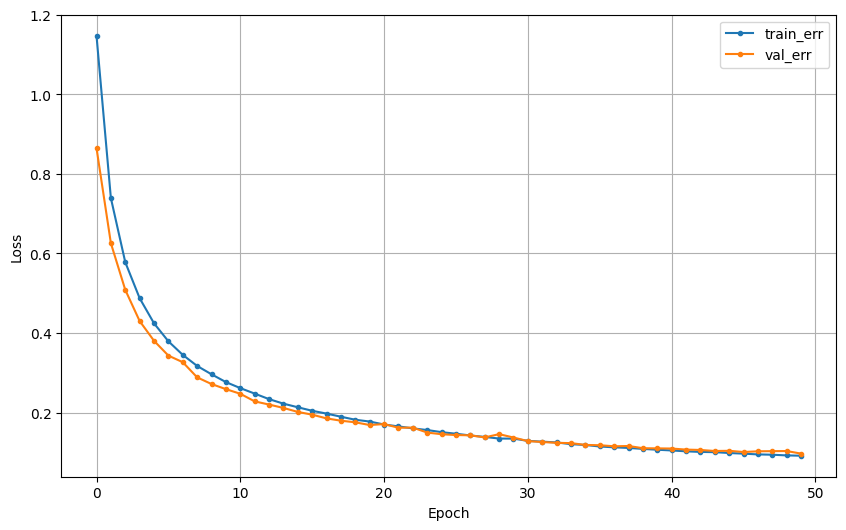

In [ ]:
dl_history_plot(history)

### (2) 모델2

In [ ]:
model2 = Sequential([Dense(64, activation='relu', input_shape=(x_train.shape[1], )),
                        Dense(32, activation='relu'),
                        Dense(16, activation='relu'),
                        Dense(8, activation='relu'),
                        Dense(6, activation='softmax')])
model2.summary()
model2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')
history = model2.fit(x_train, y_train, epochs=50, validation_split=0.2, verbose=0).history
pred = model2.predict(x_val)
pred = np.argmax(pred, axis=1)
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))
accuracy=accuracy_score(y_val, pred)
print(calculate_confidence_interval(accuracy,len(x_val)))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 64)                  │          35,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,766 (151.43 KB)

 Trainable params: 38,766 (151.43 KB)

 Non-trainable params: 0 (0.00 B)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[222   0   0   0   0   0]
 [  1 189   8   0   0   0]
 [  0  13 222   0   0   0]
 [  0   0   0 191   0   1]
 [  0   0   0   2 153   1]
 [  0   0   0   0   0 174]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.94      0.95      0.94       198
           2       0.97      0.94      0.95       235
           3       0.99      0.99      0.99       192
           4       1.00      0.98      0.99       156
           5       0.99      1.00      0.99       174

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

(0.9695132580104835, 0.9863066230430424)


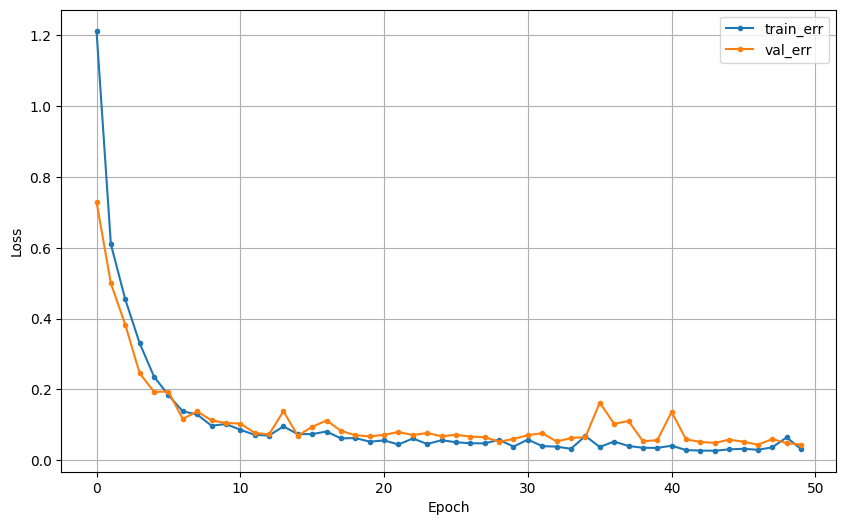

In [ ]:
dl_history_plot(history)

### (3) 모델3

In [ ]:
model3 = Sequential([Dense(64, activation='relu', input_shape=(x_train.shape[1], )),
                     Dropout(0.1),
                        Dense(32, activation='relu'),
                        Dropout(0.1),
                        Dense(16, activation='relu'),
                        Dropout(0.1),
                        Dense(8, activation='relu'),
                        Dense(6, activation='softmax')])
model3.summary()
model3.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')
history = model3.fit(x_train, y_train, epochs=50, validation_split=0.2, verbose=0).history
pred = model3.predict(x_val)
pred = np.argmax(pred, axis=1)
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))
accuracy=accuracy_score(y_val, pred)
print(calculate_confidence_interval(accuracy,len(x_val)))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 64)                  │          35,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,766 (151.43 KB)

 Trainable params: 38,766 (151.43 KB)

 Non-trainable params: 0 (0.00 B)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[222   0   0   0   0   0]
 [  1 189   8   0   0   0]
 [  0   8 227   0   0   0]
 [  0   0   0 192   0   0]
 [  0   0   0   4 152   0]
 [  0   0   0   4   0 170]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.96      0.95      0.96       198
           2       0.97      0.97      0.97       235
           3       0.96      1.00      0.98       192
           4       1.00      0.97      0.99       156
           5       1.00      0.98      0.99       174

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

(0.9705223576333794, 0.9869967587642418)


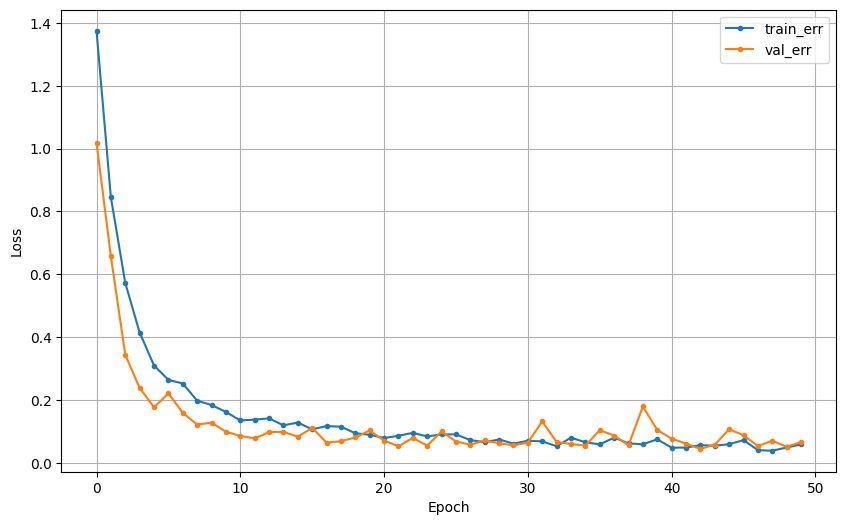

In [ ]:
dl_history_plot(history)

### (4) 모델4

In [ ]:
es = EarlyStopping(min_delta=0.001, patience=5)
model4 = Sequential([Dense(64, activation='relu', input_shape=(x_train.shape[1], )),
                    Dropout(0.1),
                    Dense(32, activation='relu'),
                    Dropout(0.1),
                    Dense(16, activation='relu'),
                    Dropout(0.1),
                    Dense(8, activation='relu'),
                    Dense(6, activation='softmax')])
model4.summary()
model4.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')
hist = model4.fit(x_train, y_train, epochs = 50, validation_split=0.2,callbacks = [es]).history
pred = model4.predict(x_val)

pred = np.argmax(pred, axis=1)
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))
accuracy=accuracy_score(y_val, pred)
print(calculate_confidence_interval(accuracy,len(x_val)))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                     │ (None, 64)                  │          35,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,766 (151.43 KB)

 Trainable params: 38,766 (151.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.4794 - val_loss: 0.8429
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8310 - val_loss: 0.4661
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5324 - val_loss: 0.3888
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4453 - val_loss: 0.3525
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3793 - val_loss: 0.3137
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3671 - val_loss: 0.2855
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3539 - val_loss: 0.2702
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2936 - val_loss: 0.2314
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2845 - val_loss: 0.2200
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2527 - val_loss: 0.2114
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2543 - val_loss: 0.2046
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

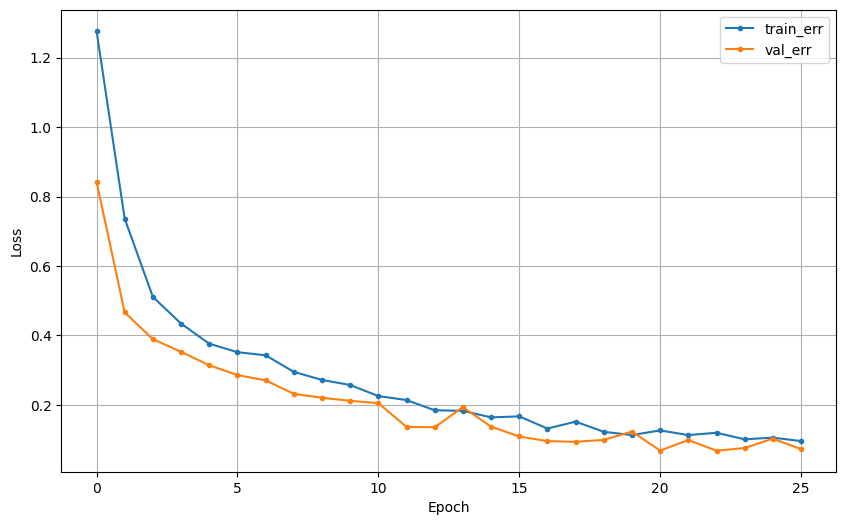

In [ ]:
dl_history_plot(hist)

### (5) 모델5

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 64)                  │          35,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,766 (151.43 KB)

 Trainable params: 38,766 (151.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.6375 - val_loss: 1.0242
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0761 - val_loss: 0.5997
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7464 - val_loss: 0.4403
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6156 - val_loss: 0.3576
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4946 - val_loss: 0.3166
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4105 - val_loss: 0.2364
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3958 - val_loss: 0.2093
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3412 - val_loss: 0.1767
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2960 - val_loss: 0.2158
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2999 - val_loss: 0.1486
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2520 - val_loss: 0.1425
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

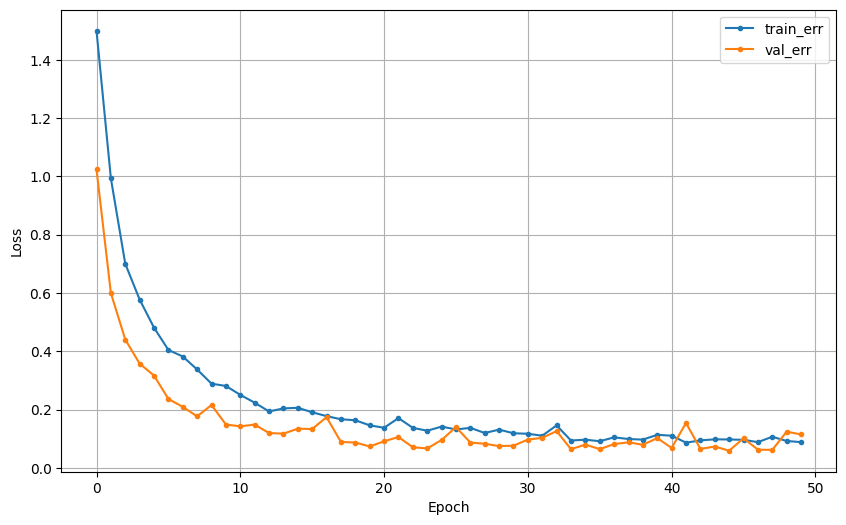

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[222   0   0   0   0   0]
 [  1 159  38   0   0   0]
 [  0   2 233   0   0   0]
 [  0   0   0 192   0   0]
 [  0   0   0   7 148   1]
 [  0   0   0   2   0 172]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.99      0.80      0.89       198
           2       0.86      0.99      0.92       235
           3       0.96      1.00      0.98       192
           4       1.00      0.95      0.97       156
           5       0.99      0.99      0.99       174

    accuracy                           0.96      1177
   macro avg       0.97      0.96      0.96      1177
weighted avg       0.96      0.96      0.96      1177

(0.9450379463645756, 0.9683010510865714)


In [ ]:
model5 = Sequential([Dense(64, activation='relu', input_shape=(x_train.shape[1], )),
                    Dropout(0.2),
                    Dense(32, activation='relu'),
                    Dropout(0.2),
                    Dense(16, activation='relu'),
                    Dropout(0.2),
                    Dense(8, activation='relu'),
                    Dense(6, activation='softmax')])
model5.summary()
model5.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')
history = model5.fit(x_train, y_train, epochs=50, validation_split=0.2).history
dl_history_plot(history)
pred = model5.predict(x_val)
pred = np.argmax(pred, axis=1)
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))
accuracy=accuracy_score(y_val, pred)
print(calculate_confidence_interval(accuracy,len(x_val)))

### (6) 모델 6

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                     │ (None, 64)                  │          35,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,766 (151.43 KB)

 Trainable params: 38,766 (151.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.6303 - val_loss: 1.0095
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0402 - val_loss: 0.5670
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6595 - val_loss: 0.4079
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5378 - val_loss: 0.3614
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4721 - val_loss: 0.2683
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4184 - val_loss: 0.2557
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3776 - val_loss: 0.2571
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3348 - val_loss: 0.2025
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3175 - val_loss: 0.1892
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3007 - val_loss: 0.1927
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2528 - val_loss: 0.1438
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

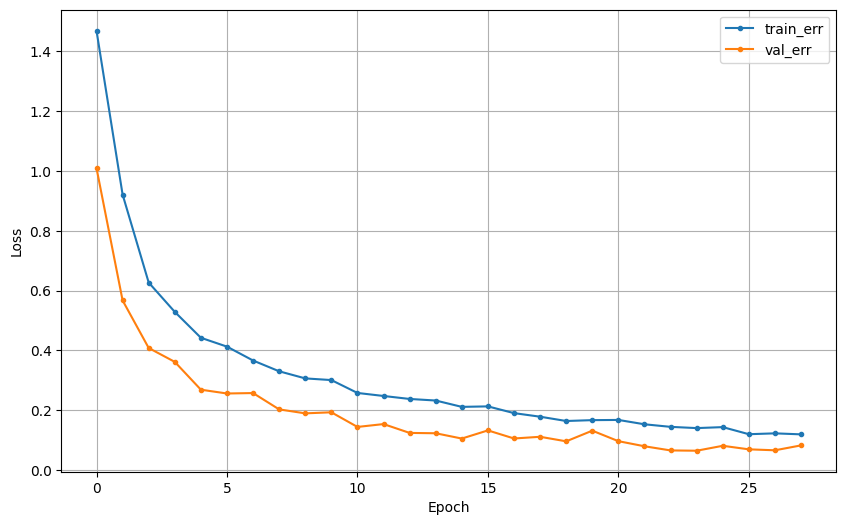

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[222   0   0   0   0   0]
 [  1 193   4   0   0   0]
 [  0  35 200   0   0   0]
 [  0   0   0 188   2   2]
 [  0   0   0   0 156   0]
 [  0   0   0   0   3 171]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.85      0.97      0.91       198
           2       0.98      0.85      0.91       235
           3       1.00      0.98      0.99       192
           4       0.97      1.00      0.98       156
           5       0.99      0.98      0.99       174

    accuracy                           0.96      1177
   macro avg       0.96      0.96      0.96      1177
weighted avg       0.96      0.96      0.96      1177

(0.9488820535742324, 0.9712538852532953)


In [ ]:
es = EarlyStopping(min_delta=0.001, patience=5)
model6 = Sequential([Dense(64, activation='relu', input_shape=(x_train.shape[1], )),
                    Dropout(0.2),
                    Dense(32, activation='relu'),
                    Dropout(0.2),
                    Dense(16, activation='relu'),
                    Dropout(0.2),
                    Dense(8, activation='relu'),
                    Dense(6, activation='softmax')])
model6.summary()
model6.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')
history = model6.fit(x_train, y_train, epochs = 50, validation_split=0.2,callbacks = [es]).history
dl_history_plot(history)
pred = model6.predict(x_val)
pred = np.argmax(pred, axis=1)
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))
accuracy=accuracy_score(y_val, pred)
print(calculate_confidence_interval(accuracy,len(x_val)))

### (7) 모델7

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                     │ (None, 64)                  │          35,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,246 (149.40 KB)

 Trainable params: 38,246 (149.40 KB)

 Non-trainable params: 0 (0.00 B)

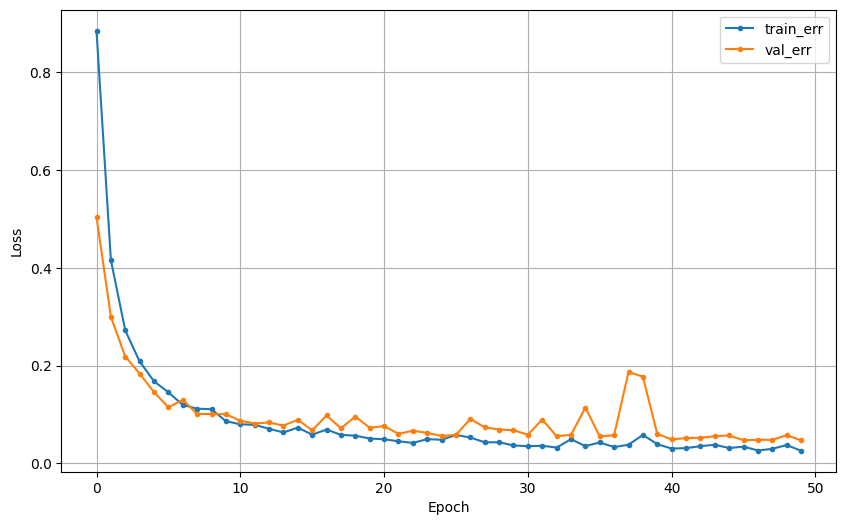

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[222   0   0   0   0   0]
 [  1 187  10   0   0   0]
 [  0  10 225   0   0   0]
 [  0   0   0 192   0   0]
 [  0   0   0   2 154   0]
 [  0   0   0   1   0 173]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.95      0.94      0.95       198
           2       0.96      0.96      0.96       235
           3       0.98      1.00      0.99       192
           4       1.00      0.99      0.99       156
           5       1.00      0.99      1.00       174

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177

(0.9715348983723304, 0.9876834533693859)


In [ ]:
model7 = Sequential([Dense(64, activation='relu', input_shape=(x_train.shape[1], )),
                        Dense(32, activation='relu'),
                        Dense(6, activation='softmax')])
model7.summary()
model7.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')
history = model7.fit(x_train, y_train, epochs=50, validation_split=0.2, verbose=0).history
dl_history_plot(history)
pred = model7.predict(x_val)
pred = np.argmax(pred, axis=1)
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))
accuracy=accuracy_score(y_val, pred)
print(calculate_confidence_interval(accuracy,len(x_val)))

### (8) 모델 8

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                     │ (None, 64)                  │          35,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,246 (149.40 KB)

 Trainable params: 38,246 (149.40 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2739 - val_loss: 0.5287
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5549 - val_loss: 0.3257
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3746 - val_loss: 0.2583
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3018 - val_loss: 0.1956
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2324 - val_loss: 0.1809
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2105 - val_loss: 0.1283
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1778 - val_loss: 0.1156
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1515 - val_loss: 0.1132
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1315 - val_loss: 0.0975
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1250 - val_loss: 0.1068
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1225 - val_loss: 0.0983
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

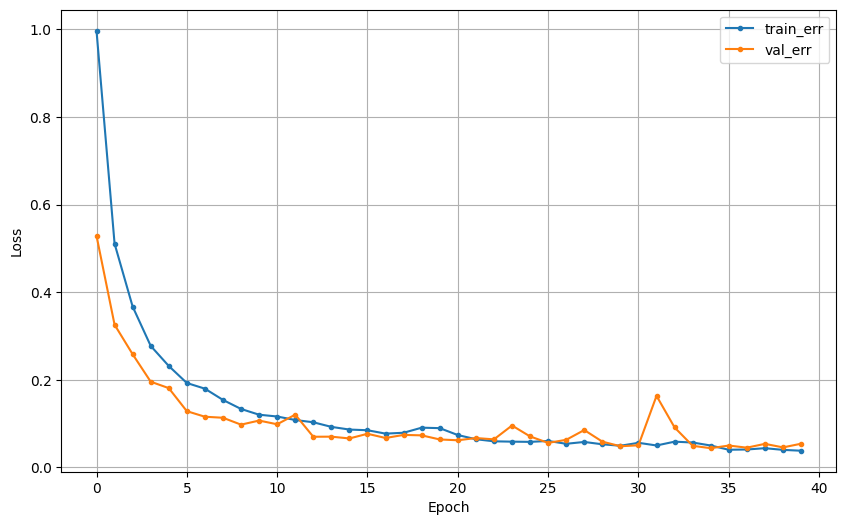

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[222   0   0   0   0   0]
 [  0 179  19   0   0   0]
 [  0   4 231   0   0   0]
 [  0   0   0 192   0   0]
 [  0   0   0   5 149   2]
 [  0   0   0   2   0 172]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.98      0.90      0.94       198
           2       0.92      0.98      0.95       235
           3       0.96      1.00      0.98       192
           4       1.00      0.96      0.98       156
           5       0.99      0.99      0.99       174

    accuracy                           0.97      1177
   macro avg       0.98      0.97      0.97      1177
weighted avg       0.97      0.97      0.97      1177

(0.9635212629651656, 0.9821032060237894)


In [ ]:
es = EarlyStopping(min_delta=0.001, patience=5)
model8 = Sequential([Dense(64, activation='relu', input_shape=(x_train.shape[1], )),
                        Dropout(0.1),
                        Dense(32, activation='relu'),
                        Dropout(0.1),
                        Dense(6, activation='softmax')])
model8.summary()
model8.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')
history = model8.fit(x_train, y_train, epochs = 50, validation_split=0.2,callbacks = [es]).history
dl_history_plot(history)
pred = model8.predict(x_val)
pred = np.argmax(pred, axis=1)
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))
accuracy=accuracy_score(y_val, pred)
print(calculate_confidence_interval(accuracy,len(x_val)))

### (9) 모델 9

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                     │ (None, 64)                  │          35,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 6)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,678 (151.09 KB)

 Trainable params: 38,678 (151.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.5841 - val_loss: 0.8704
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9678 - val_loss: 0.5412
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6878 - val_loss: 0.3483
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5025 - val_loss: 0.2666
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4161 - val_loss: 0.2155
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3369 - val_loss: 0.1742
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3260 - val_loss: 0.1408
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2691 - val_loss: 0.1479
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2588 - val_loss: 0.1272
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2374 - val_loss: 0.1248
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2233 - val_loss: 0.1305
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

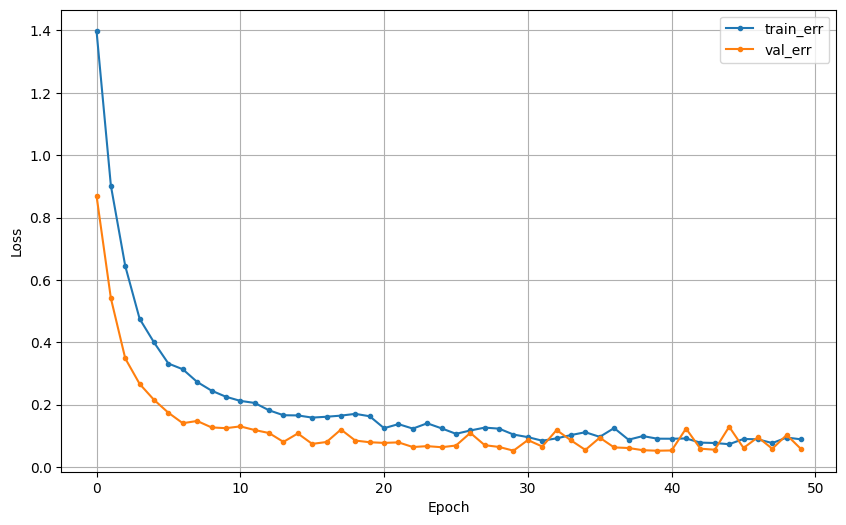

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[222   0   0   0   0   0]
 [  1 176  21   0   0   0]
 [  0   5 230   0   0   0]
 [  0   0   0 190   0   2]
 [  0   0   0   0 154   2]
 [  0   0   0   0   0 174]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.97      0.89      0.93       198
           2       0.92      0.98      0.95       235
           3       1.00      0.99      0.99       192
           4       1.00      0.99      0.99       156
           5       0.98      1.00      0.99       174

    accuracy                           0.97      1177
   macro avg       0.98      0.97      0.97      1177
weighted avg       0.97      0.97      0.97      1177

(0.9645132118696513, 0.9828104924633987)


In [ ]:
model9 = Sequential([Dense(64, activation='relu', input_shape=(x_train.shape[1], )),
                        Dropout(0.2),
                        Dense(32, activation='relu'),
                        Dropout(0.2),
                        Dense(16, activation='relu'),
                        Dropout(0.2),
                        Dense(6, activation='softmax')])
model9.summary()
model9.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')
history = model9.fit(x_train, y_train, epochs=50, validation_split=0.2).history
dl_history_plot(history)
pred = model9.predict(x_val)
pred = np.argmax(pred, axis=1)
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))
accuracy=accuracy_score(y_val, pred)
print(calculate_confidence_interval(accuracy,len(x_val)))

### (10) 모델 10

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                     │ (None, 64)                  │          35,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 6)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,678 (151.09 KB)

 Trainable params: 38,678 (151.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.4748 - val_loss: 0.7981
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9098 - val_loss: 0.5482
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6940 - val_loss: 0.4010
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5327 - val_loss: 0.2887
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4123 - val_loss: 0.2504
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3672 - val_loss: 0.1946
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3510 - val_loss: 0.1577
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3055 - val_loss: 0.1604
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2620 - val_loss: 0.1159
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2713 - val_loss: 0.1342
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2299 - val_loss: 0.1816
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

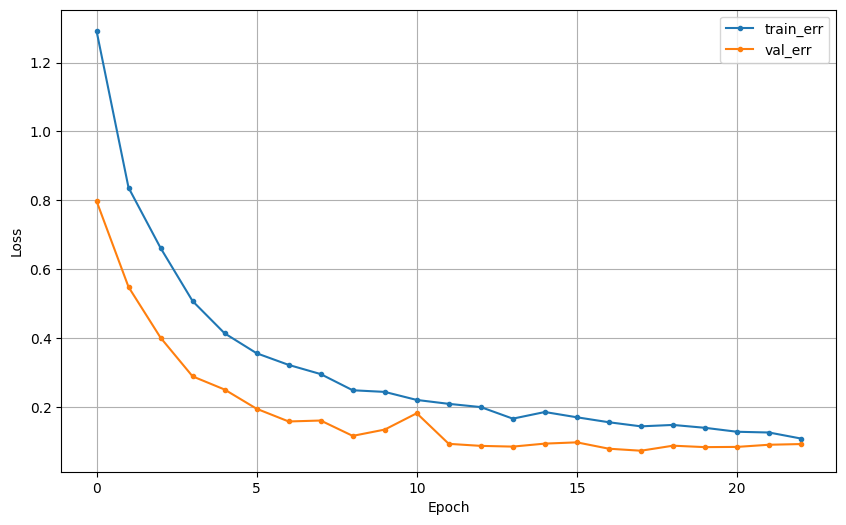

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[222   0   0   0   0   0]
 [  1 194   3   0   0   0]
 [  0  37 198   0   0   0]
 [  0   0   0 190   1   1]
 [  0   0   0   0 156   0]
 [  0   0   0   4   2 168]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       0.84      0.98      0.90       198
           2       0.99      0.84      0.91       235
           3       0.98      0.99      0.98       192
           4       0.98      1.00      0.99       156
           5       0.99      0.97      0.98       174

    accuracy                           0.96      1177
   macro avg       0.96      0.96      0.96      1177
weighted avg       0.96      0.96      0.96      1177

(0.9469574113784301, 0.9697800567609071)


In [ ]:
es = EarlyStopping(min_delta=0.001, patience=5)
model10 = Sequential([Dense(64, activation='relu', input_shape=(x_train.shape[1], )),
                        Dropout(0.2),
                        Dense(32, activation='relu'),
                        Dropout(0.2),
                        Dense(16, activation='relu'),
                        Dropout(0.2),
                        Dense(6, activation='softmax')])
model10.summary()
model10.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')
history = model10.fit(x_train, y_train, epochs = 50, validation_split=0.2,callbacks = [es]).history
dl_history_plot(history)
pred = model10.predict(x_val)
pred = np.argmax(pred, axis=1)
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))
accuracy=accuracy_score(y_val, pred)
print(calculate_confidence_interval(accuracy,len(x_val)))

## 추가

### (11) 모델 11

In [ ]:
# 데이터 로드 및 전처리
train_data = pd.read_csv('/content/drive/MyDrive/project3/data01_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/project3/data01_test.csv')

# 필요없는 컬럼 제거
train_data.drop('subject', axis=1, inplace=True)
test_data.drop('subject', axis=1, inplace=True)

# x_train, x_val 정의 ('Activity'를 제외한 feature와 target 분리)
x_train = train_data.drop('Activity', axis=1)
x_val = test_data.drop('Activity', axis=1)
y_train = train_data['Activity']
y_val = test_data['Activity']

# y_train과 y_val을 정수로 변환
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['Activity'])
y_val = label_encoder.transform(test_data['Activity'])

# feature importance 로드
features = joblib.load('/content/drive/MyDrive/project3/feature_importance.pkl')
features = features.drop('feature_importance_dynamic', axis=1)

In [ ]:
# feature_importances 및 x_train 크기 확인
feature_importances = features['feature_importance_activity'].values
print(f"x_train.shape: {x_train.shape}")
print(f"feature_importances.shape: {feature_importances.shape}")

# feature_names 생성
feature_names = x_train.columns.tolist()

# 상위 25% feature 선택
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
threshold = importance_df['Importance'].quantile(0.75)
top_25_features = importance_df[importance_df['Importance'] >= threshold]['Feature'].tolist()

# 상위 25% feature를 사용하여 데이터 재구성
x_train_top_25 = x_train[top_25_features]
x_val_top_25 = x_val[top_25_features]

print(f"x_train_top_25.shape: {x_train_top_25.shape}")
print(f"x_val_top_25.shape: {x_val_top_25.shape}")

x_train.shape: (5881, 561)
feature_importances.shape: (561,)
x_train_top_25.shape: (5881, 141)
x_val_top_25.shape: (1471, 141)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                     │ (None, 6)                   │             852 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 852 (3.33 KB)

 Trainable params: 852 (3.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5414 - val_loss: 0.9998
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9401 - val_loss: 0.7653
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7448 - val_loss: 0.6550
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6399 - val_loss: 0.5766
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5716 - val_loss: 0.5175
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5209 - val_loss: 0.4751
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4676 - val_loss: 0.4454
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4466 - val_loss: 0.4182
Epoch 9/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4165 - val_loss: 0.3956
Epoch 10/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3945 - val_loss: 0.3831
Epoch 11/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3716 - val_loss: 0.3620
Epoch 12/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

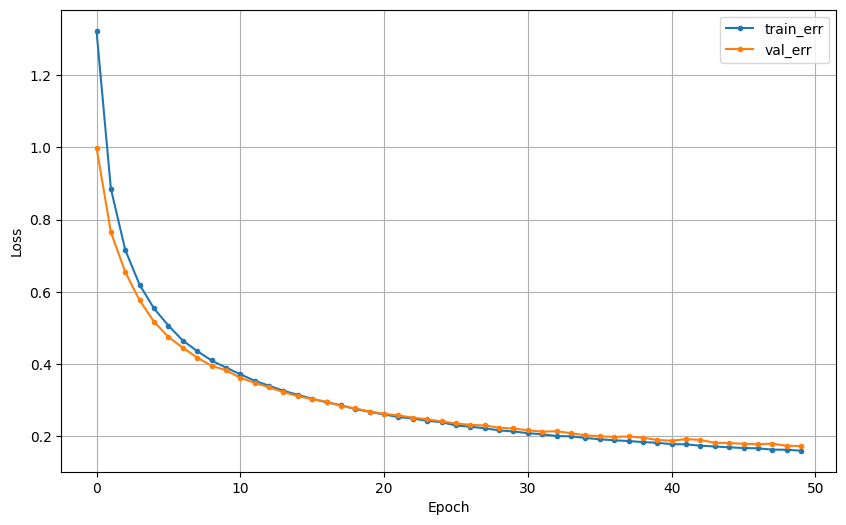

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[290   2   0   0   0   0]
 [  1 224  28   0   0   1]
 [  0  46 240   0   0   1]
 [  0   0   0 220   0   8]
 [  0   0   0   5 186   4]
 [  0   0   0   6   2 207]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       292
           1       0.82      0.88      0.85       254
           2       0.90      0.84      0.86       287
           3       0.95      0.96      0.96       228
           4       0.99      0.95      0.97       195
           5       0.94      0.96      0.95       215

    accuracy                           0.93      1471
   macro avg       0.93      0.93      0.93      1471
weighted avg       0.93      0.93      0.93      1471

(0.916201041367167, 0.942398550747041)


In [ ]:
# 딥러닝 모델 정의 (상위 25% 변수만 사용)
model11 = Sequential([Dense(6, activation='softmax', input_shape=(x_train_top_25.shape[1],))])
model11.summary()

# 모델 컴파일 (sparse_categorical_crossentropy 사용)
model11.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy')

# 모델 학습
history = model11.fit(x_train_top_25, y_train, epochs=50, validation_split=0.2).history

# 학습 결과 시각화
dl_history_plot(history)

# 모델 예측 및 평가
pred = model11.predict(x_val_top_25)
pred = np.argmax(pred, axis=1)
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))
accuracy = accuracy_score(y_val, pred)
print(calculate_confidence_interval(accuracy, len(x_val_top_25)))

### (12) 모델 12

In [ ]:
# feature_importances 및 x_train 크기 확인
feature_importances = features['feature_importance_activity'].values
print(f"x_train.shape: {x_train.shape}")
print(f"feature_importances.shape: {feature_importances.shape}")

# feature_names 생성
feature_names = x_train.columns.tolist()

# 상위 50% feature 선택
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
threshold = importance_df['Importance'].quantile(0.5)
top_50_features = importance_df[importance_df['Importance'] >= threshold]['Feature'].tolist()

# 상위 50% feature를 사용하여 데이터 재구성
x_train_top_50 = x_train[top_50_features]
x_val_top_50 = x_val[top_50_features]

print(f"x_train_top_50.shape: {x_train_top_50.shape}")
print(f"x_val_top_50.shape: {x_train_top_50.shape}")

x_train.shape: (5881, 561)
feature_importances.shape: (561,)
x_train_top_50.shape: (5881, 281)
x_val_top_50.shape: (5881, 281)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                     │ (None, 6)                   │           1,692 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,692 (6.61 KB)

 Trainable params: 1,692 (6.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4285 - val_loss: 0.8090
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7441 - val_loss: 0.5963
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5709 - val_loss: 0.4866
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4784 - val_loss: 0.4244
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4186 - val_loss: 0.3821
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3582 - val_loss: 0.3488
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3312 - val_loss: 0.3245
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3094 - val_loss: 0.2988
Epoch 9/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2891 - val_loss: 0.2826
Epoch 10/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2677 - val_loss: 0.2682
Epoch 11/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2531 - val_loss: 0.2535
Epoch 12/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

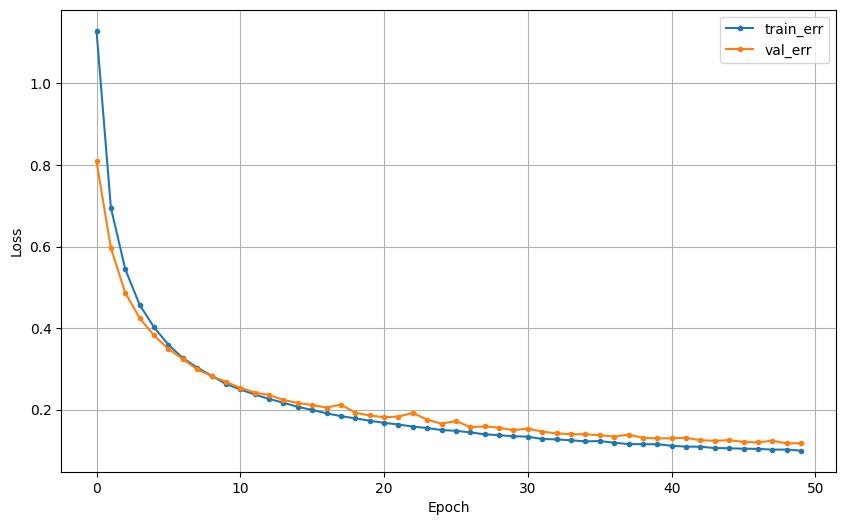

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[289   0   0   0   3   0]
 [  1 235  18   0   0   0]
 [  0  36 250   0   0   1]
 [  0   0   0 226   0   2]
 [  0   0   0   1 193   1]
 [  0   0   0   5   0 210]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       292
           1       0.87      0.93      0.90       254
           2       0.93      0.87      0.90       287
           3       0.97      0.99      0.98       228
           4       0.98      0.99      0.99       195
           5       0.98      0.98      0.98       215

    accuracy                           0.95      1471
   macro avg       0.96      0.96      0.96      1471
weighted avg       0.95      0.95      0.95      1471

(0.9430426309857913, 0.9645032561658062)


In [ ]:
# 모델 12의 경우 상위 50% feature 사용
# 딥러닝 모델 정의 (상위 50% 변수만 사용)
model12 = Sequential([Dense(6, activation='softmax', input_shape=(x_train_top_50.shape[1],))])
model12.summary()

# 모델 컴파일 (sparse_categorical_crossentropy 사용)
model12.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy')

# 모델 학습
history = model12.fit(x_train_top_50, y_train, epochs=50, validation_split=0.2).history

# 학습 결과 시각화
dl_history_plot(history)

# 모델 예측 및 평가 (상위 50% feature 사용)
pred = model12.predict(x_val_top_50)
pred = np.argmax(pred, axis=1)
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))
accuracy = accuracy_score(y_val, pred)
print(calculate_confidence_interval(accuracy, len(x_val_top_50)))


## 4.성능비교

In [ ]:
x_test = test_data.drop('Activity', axis=1)
y_test = test_data.loc[:, 'Activity']
scaler = MinMaxScaler()
x_test = scaler.fit_transform(x_test)
encoder = LabelEncoder()
y_test = encoder.fit_transform(y_test)

In [ ]:
# 모델 리스트 생성
models = [model1, model2, model3, model4, model5, model6, model7, model8, model9, model10]

# 스케일러와 레이블 인코더 적용
x_test = test_data.drop('Activity', axis=1)
y_test = test_data['Activity']
scaler = MinMaxScaler()
x_test = scaler.fit_transform(x_test)

encoder = LabelEncoder()
y_test = encoder.fit_transform(y_test)

# 모델별 정확도 계산
test_model_scores = []
for model in models:
    pred = model.predict(x_test)
    pred = pred.argmax(axis=1)
    test_model_scores.append(accuracy_score(y_test, pred))

# 결과 출력
print(test_model_scores)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[0.95581237253569, 0.9598912304554724, 0.9510537049626104, 0.9415363698164514, 0.9259007477906186, 0.9673691366417403, 0.9612508497620667, 0.9537729435757988, 0.9551325628823929, 0.9612508497620667]


In [ ]:
test_model_scores

[0.95581237253569,
 0.9598912304554724,
 0.9510537049626104,
 0.9415363698164514,
 0.9259007477906186,
 0.9673691366417403,
 0.9612508497620667,
 0.9537729435757988,
 0.9551325628823929,
 0.9612508497620667]

In [ ]:
test_model_scores = pd.DataFrame(test_model_scores)
test_model_scores.index += 1
test_model_scores

,0
1,0.955812
2,0.959891
3,0.951054
4,0.941536
5,0.925901
6,0.967369
7,0.961251
8,0.953773
9,0.955133
10,0.961251
